In [1]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, \
    Flatten, Lambda, LSTM, RepeatVector, TimeDistributed, Reshape, \
    Conv2D, MaxPooling2D, BatchNormalization, ConvLSTM2D, Bidirectional
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import json

/home/weihangzhang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # models
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.resnet50 import ResNet50

In [3]:
data = h5py.File("./data_sample.hdf5", "r")
print("data keys: " + str(list(data.keys())))

data keys: ['images', 'labels', 'observation_days']


In [4]:
images = data["images"][:]
print("image shape: (sample, x_size, y_size, epoch) = " + str(images.shape))
labels = data["labels"][:]

image shape: (sample, x_size, y_size, epoch) = (72000, 21, 21, 48)


In [5]:
def scale_images(images):
    t_images = np.transpose(images, (0,3,1,2))
    rt_images = t_images.reshape(72000*48, 21, 21)
    max_per_img = np.max(rt_images.reshape(-1, 21*21), axis=1, keepdims=1)
    scaled_images = rt_images.reshape(-1, 21*21) / max_per_img
    scaled_images = scaled_images.reshape(-1, 21, 21).reshape(-1, 48, 21, 21)
    return scaled_images

In [6]:
def txt2digit(labels):
    dic = {'Asteroids':0, 'Constant':1, 'EmptyLigh':2, 'M33Cephei':3, 'RRLyrae':4, 'Supernova':5}
    labels_digit = np.array([dic[i] for i in labels])
    return labels_digit

In [7]:
def build_dataset(images, labels, seq2seq=False):
    
    train_indices = np.random.choice(np.arange(images.shape[0]), int( 0.7 * images.shape[0]))
    val_indices = list(set(np.arange(images.shape[0])) - set(train_indices))
    
    x = np.transpose(images, (0, 3, 1, 2))
    x = np.expand_dims(x, len(x.shape))
    y = to_categorical(txt2digit(labels))
    
    if seq2seq:
        y = np.repeat(y, 48).reshape(-1, 48, 6)
    
    return x, y

In [8]:
x, y = build_dataset(images, labels)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=209, stratify=y)

In [10]:
x_train.shape

(57600, 48, 21, 21, 1)

In [38]:
def init_model3(cnn_input_dim=21, cnn_output_dim=128, cnn_dropout=0.5,
               rnn_hidden_dim=128, rnn_output_dim=64, num_classes=6, rnn_dropout=0.5, timestep=48,
               bidir_mode='concat'):
    
    input_shape = (timestep, cnn_input_dim, cnn_input_dim, 1, )
    
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(48, (4,4), \
                     padding='same', activation='relu', kernel_initializer='uniform'), input_shape=input_shape))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(BatchNormalization(momentum=0.4))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1))))
    
    model.add(TimeDistributed(Conv2D(24, (3,3), padding='same', activation='relu', kernel_initializer='uniform')))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(BatchNormalization(momentum=0.4))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1))))

    model.add(TimeDistributed(Conv2D(12, (3,3), padding='same', activation='relu', kernel_initializer='uniform')))
    model.add(TimeDistributed(BatchNormalization(momentum=0.3)))
#     model.add(BatchNormalization(momentum=0.4))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1))))
    
    model.add(TimeDistributed(Flatten()))

    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(Dropout(0.25))
    
    model.add(LSTM(rnn_hidden_dim, dropout=rnn_dropout, return_sequences=True))
    model.add(LSTM(rnn_hidden_dim, dropout=rnn_dropout))
    
    model.add(Dense(6, activation='softmax'))
    
    return model

In [39]:
opt = keras.optimizers.Adam(lr=5*1e-4)
model3 = init_model3(bidir_mode='ave')
model3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_71 (TimeDis (None, 48, 21, 21, 48)    816       
_________________________________________________________________
time_distributed_72 (TimeDis (None, 48, 19, 19, 48)    0         
_________________________________________________________________
time_distributed_73 (TimeDis (None, 48, 19, 19, 24)    10392     
_________________________________________________________________
time_distributed_74 (TimeDis (None, 48, 17, 17, 24)    0         
_________________________________________________________________
time_distributed_75 (TimeDis (None, 48, 17, 17, 12)    2604      
_________________________________________________________________
time_distributed_76 (TimeDis (None, 48, 17, 17, 12)    48        
_________________________________________________________________
time_distributed_77 (TimeDis (None, 48, 15, 15, 12)    0         
__________

In [ ]:
batch_size = 100
epochs = 100

checkpoint = keras.callbacks.ModelCheckpoint('best_checkpoint/batchnorm_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model3_fit = model3.fit(x_train[::4], y_train[::4],
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              callbacks=[checkpoint],
              shuffle=True)

Train on 14400 samples, validate on 14400 samples
Epoch 1/100
14400/14400 [==============================] - 46s 3ms/step - loss: 1.4938 - acc: 0.3337 - val_loss: 3.7355 - val_acc: 0.1837

Epoch 00001: val_acc improved from -inf to 0.18375, saving model to best_checkpoint/batchnorm_best.hdf5
Epoch 2/100
14400/14400 [==============================] - 42s 3ms/step - loss: 1.1833 - acc: 0.4312 - val_loss: 4.4196 - val_acc: 0.1877

Epoch 00002: val_acc improved from 0.18375 to 0.18771, saving model to best_checkpoint/batchnorm_best.hdf5
Epoch 3/100
14400/14400 [==============================] - 42s 3ms/step - loss: 1.1359 - acc: 0.4391 - val_loss: 1.0375 - val_acc: 0.4617

Epoch 00003: val_acc improved from 0.18771 to 0.46167, saving model to best_checkpoint/batchnorm_best.hdf5
Epoch 4/100
14400/14400 [==============================] - 42s 3ms/step - loss: 1.0694 - acc: 0.4604 - val_loss: 0.9941 - val_acc: 0.4926

Epoch 00004: val_acc improved from 0.46167 to 0.49264, saving model to best_

14400/14400 [==============================] - 40s 3ms/step - loss: 0.7527 - acc: 0.6001 - val_loss: 0.7484 - val_acc: 0.6022

Epoch 00038: val_acc did not improve from 0.62382
Epoch 39/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.7542 - acc: 0.6033 - val_loss: 0.7383 - val_acc: 0.6231

Epoch 00039: val_acc did not improve from 0.62382
Epoch 40/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.7508 - acc: 0.6031 - val_loss: 1.7769 - val_acc: 0.3824

Epoch 00040: val_acc did not improve from 0.62382
Epoch 41/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.7645 - acc: 0.6044 - val_loss: 0.7369 - val_acc: 0.6081

Epoch 00041: val_acc did not improve from 0.62382
Epoch 42/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.7465 - acc: 0.6137 - val_loss: 0.7425 - val_acc: 0.6327

Epoch 00042: val_acc improved from 0.62382 to 0.63271, saving model to best_checkpoint/batchnorm_best.hdf5
Epoch 

14400/14400 [==============================] - 42s 3ms/step - loss: 0.5367 - acc: 0.7438 - val_loss: 0.5521 - val_acc: 0.7553

Epoch 00077: val_acc did not improve from 0.76611
Epoch 78/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.5278 - acc: 0.7466 - val_loss: 0.5011 - val_acc: 0.7731

Epoch 00078: val_acc improved from 0.76611 to 0.77306, saving model to best_checkpoint/batchnorm_best.hdf5
Epoch 79/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.5310 - acc: 0.7503 - val_loss: 0.5286 - val_acc: 0.7657

Epoch 00079: val_acc did not improve from 0.77306
Epoch 80/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.5368 - acc: 0.7453 - val_loss: 0.5251 - val_acc: 0.7592

Epoch 00080: val_acc did not improve from 0.77306
Epoch 81/100
14400/14400 [==============================] - 42s 3ms/step - loss: 0.5253 - acc: 0.7525 - val_loss: 0.5571 - val_acc: 0.7616

Epoch 00081: val_acc did not improve from 0.77306
Epoch 

In [ ]:
with open('batch_norm_history.json', 'w') as f:
    json.dump(model3_fit.history, f)

In [ ]:
plt.figure(figsize=(8,8 ))
plt.plot(range(len(model3_fit.history['acc'])),\
         model3_fit.history['acc'], label='Training set accuracy')
plt.plot(range(len(model3_fit.history['acc'])), \
         model3_fit.history['val_acc'], label='Testing set accuracy')
plt.legend()
plt.show()

Load saved best model and visualize the confusion matrix

In [39]:
model = keras.models.load_model('saved_models/rcnn_simple_lstm_ep300.hdf5')

In [40]:
def compute_confusion_matrix(model, x, y):
    from sklearn.metrics import confusion_matrix
    pred = model.predict_classes(x)
    labels = y @ np.array([0,1,2,3,4,5]).T
    cm = confusion_matrix(labels, pred)
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.grid(False)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


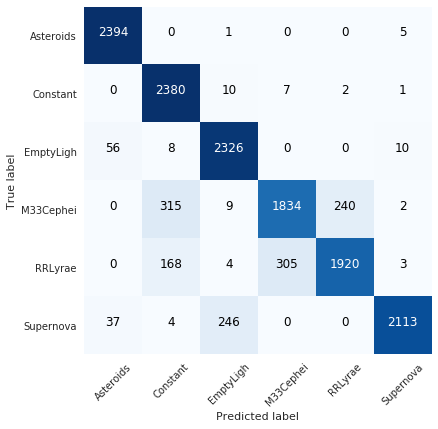

In [41]:
cm = compute_confusion_matrix(model, x_test, y_test)
plot_confusion_matrix(cm, classes=['Asteroids', 'Constant', 'EmptyLigh', 'M33Cephei', 'RRLyrae', 'Supernova'])